In [1]:
#!pip install --upgrade pip
#!pip install --upgrade setuptools
#!pip install GEOS
#!pip install GeobricksProj4ToEPSG
#!conda install -c conda-forge cartopy --yes
#!pip install geopandas
print('ok')

ok


In [2]:
import os
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML
import geopandas as gpd
import time

os.chdir('/home/idies/workspace/Temporary/raddick/cra_scratch/')
print(os.getcwd())

/home/idies/workspace/Temporary/raddick/cra_scratch


In [3]:
s = time.time()
nfile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/Neighborhoods.shp'
neighborhood_gdf = gpd.read_file(nfile)
neighborhood_gdf = neighborhood_gdf.set_index('Name')
e = time.time()
print('Read {0:,.0f} neighborhoods in {1:.3f} seconds.'.format(len(neighborhood_gdf), e-s))

s = time.time()
tracts_2010_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/census_tracts_2010/geo_export_c50bbe56-543e-4878-9c9f-c56be327600a.shp', encoding='utf-8')
tracts_2010_gdf = tracts_2010_gdf.assign(tractname=pandas.to_numeric(tracts_2010_gdf['name'].apply(lambda x: x.split(' ')[-1]), errors='coerce'))
tracts_2010_gdf = tracts_2010_gdf.set_index('tractname')
tracts_2010_gdf = tracts_2010_gdf.to_crs(neighborhood_gdf.crs)
e = time.time()
print('Got {0:,.0f} 2010 census tracts in {1:.3f} seconds.'.format(len(tracts_2010_gdf), e-s))

s = time.time()
tracts_2017_gdf = gpd.read_file('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/tl_2017_24_tract/tl_2017_24_tract.shp', encoding='utf-8')
tracts_2017_gdf['STATEFP'] = pandas.to_numeric(tracts_2017_gdf['STATEFP'], errors='coerce')
tracts_2017_gdf['COUNTYFP'] = pandas.to_numeric(tracts_2017_gdf['COUNTYFP'], errors='coerce')
tracts_2017_gdf = tracts_2017_gdf[(tracts_2017_gdf['STATEFP'] == 24) & (tracts_2017_gdf['COUNTYFP'] == 510)]
tracts_2017_gdf = tracts_2017_gdf.assign(tractname = pandas.to_numeric(tracts_2017_gdf['NAME'], errors='coerce'))
tracts_2017_gdf = tracts_2017_gdf.set_index('tractname')
tracts_2017_gdf = tracts_2017_gdf.join(tracts_2010_gdf['population'], how='left')
tracts_2017_gdf = tracts_2017_gdf.to_crs(neighborhood_gdf.crs)
e = time.time()
print('Got {0:,.0f} 2017 census tracts in {1:.3f} seconds.'.format(len(tracts_2017_gdf), e-s))

s = time.time()
census_tract_to_neighborhood_df = pandas.read_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/census_tract_to_neighborhood.csv', low_memory=False)
census_tract_to_neighborhood_df['NAME10'] = pandas.to_numeric(census_tract_to_neighborhood_df['NAME10'], errors='coerce')
census_tract_to_neighborhood_df = census_tract_to_neighborhood_df.set_index('NAME10')

tract_shapes_with_csa_df = tracts_2017_gdf.join(census_tract_to_neighborhood_df, how='left')

csa_df = pandas.DataFrame(data=tract_shapes_with_csa_df.groupby('CSA2010').size(), columns=['ignore'])

csa_df = csa_df.assign(geometry='')
for thiscsa, thisrow in csa_df.iterrows():
    tracts_here = tract_shapes_with_csa_df[tract_shapes_with_csa_df['CSA2010'] == thiscsa].index.values.tolist()
    geos_here = tract_shapes_with_csa_df[tract_shapes_with_csa_df.index.isin(tracts_here)].geometry
    csa_df.loc[thiscsa, 'geometry'] = geos_here.unary_union

csa_df = csa_df.drop('ignore', axis=1)

csa_gdf = gpd.GeoDataFrame(csa_df, crs=tracts_2017_gdf.crs, geometry='geometry')
csa_gdf = csa_gdf.to_crs(neighborhood_gdf.crs)
e = time.time()

print('Assembled those census tracts into {0:,.0f} CSAs in {1:,.3f} seconds.'.format(len(csa_gdf), e-s))

s = time.time()
blockgroupfile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/cb_2017_24_bg_500k/cb_2017_24_bg_500k.shp'
block_group_gdf = gpd.read_file(blockgroupfile)
block_group_gdf['STATEFP'] = pandas.to_numeric(block_group_gdf['STATEFP'], errors='coerce')
block_group_gdf['COUNTYFP'] = pandas.to_numeric(block_group_gdf['COUNTYFP'], errors='coerce')
block_group_gdf = block_group_gdf[(block_group_gdf['STATEFP'] == 24) & (block_group_gdf['COUNTYFP'] == 510)]
block_group_gdf = block_group_gdf.to_crs(neighborhood_gdf.crs)
e = time.time()

print('Read {0:,.0f} block groups in {1:.3f} seconds.'.format(len(block_group_gdf), e-s))

outlinefile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/baltimore_city_polygon/baltimore_city_polygon.shp'
city_outline_gdf = gpd.read_file(outlinefile)
city_outline_gdf = city_outline_gdf.to_crs(neighborhood_gdf.crs)
print('\nRead city outline.')

outlinefile = '/home/idies/workspace/Storage/raddick/persistent/cra/metadata/shapefiles/water/water.shp'
water_gdf = gpd.read_file(outlinefile)
print('Read water outlines.')

print('\nDone!')

Read 278 neighborhoods in 0.145 seconds.
Got 200 2010 census tracts in 0.132 seconds.
Got 200 2017 census tracts in 0.591 seconds.
Assembled those census tracts into 56 CSAs in 0.401 seconds.
Read 653 block groups in 0.719 seconds.

Read city outline.
Read water outlines.

Done!


# Compare block groups, census tracts, and community statistical areas

In [ ]:
fig, ax = plt.subplots(figsize=(38,38))

block_group_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle=':', alpha=0.5)

tracts_2017_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle='-', alpha=0.75)

for ix, thisrow in block_group_gdf.iterrows():
    annotator = thisrow['NAME']
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=11, color='black', alpha=0.5)

for ix, thisrow in tracts_2017_gdf.iterrows():
    annotator = ix
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=18, alpha=0.75)

csa_gdf.plot(ax=ax, color='none', edgecolor='green', linewidth=4)

#for ix, thisrow in csa_gdf.iterrows():
#    annotator = ix.replace('-', '- ')
#    annotator = annotator.replace('/', '/ ')
#    annotator = annotator.replace(' ', '\n')
#    annotator = annotator.upper()
#    ax.annotate(annotator, 
#                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#               xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#              ha='center', va='center', fontsize=24, color='green')

neighborhood_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

#water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax, color='blue')

ax.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

#print('saving...')
#plt.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_boundary_guide_csa.svg', format='svg')
#print('ok')
plt.show()
#csa_gdf

# Compare block groups, census tracts, and neighborhoods

In [ ]:
fig, ax = plt.subplots(figsize=(38,38))

block_group_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle=':', alpha=0.5)

tracts_2017_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle='-')


for ix, thisrow in block_group_gdf.iterrows():
    annotator = thisrow['NAME']
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=9, color='black', alpha=0.5)

for ix, thisrow in tracts_2017_gdf.iterrows():
    annotator = ix
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=12)
    
csa_gdf.plot(ax=ax, color='none', edgecolor='green', linewidth=4)

#for ix, thisrow in csa_gdf.iterrows():
#    annotator = ix.replace('-', '- ')
#    annotator = annotator.replace('/', '/ ')
#    annotator = annotator.replace(' ', '\n')
#    annotator = annotator.upper()
#    ax.annotate(annotator, 
#                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                ha='center', va='center', fontsize=24, color='green')

neighborhood_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

for ix, thisrow in neighborhood_gdf.iterrows():
    annotator = ix.replace('-', '- ')
    annotator = annotator.replace('/', '/ ')
    annotator = annotator.replace(' ', '\n')
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=14, color='red')

#water_gdf.plot(ax=ax, color='blue')
water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax, color='blue')

ax.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')

#plt.show()
#csa_gdf
plt.savefig('/home/idies/workspace/Storage/raddick/persistent/cra/baltimore_boundary_guide.svg', format='svg')
print('ok')

In [ ]:
cols = neighborhood_gdf.columns.tolist()
cols.remove('created_us')
cols.remove('created_da')
cols.remove('last_edite')
cols.remove('last_edi_1')
cols.remove('ShapeSTAre')
cols.remove('ShapeSTLen')
cols.remove('geometry')
#os.getcwd()
neighborhood_gdf[cols].to_csv('neighborhood_full_data.csv', encoding='utf-8')
print('ok')

In [ ]:
fig, ax = plt.subplots(figsize=(38,38))

block_group_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle=':', alpha=0.5)
tracts_2017_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle='-', alpha=0.75)

for ix, thisrow in block_group_gdf.iterrows():
    annotator = thisrow['NAME']
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=11, color='black', alpha=0.5)

for ix, thisrow in tracts_2017_gdf.iterrows():
    annotator = ix
    ax.annotate(annotator, 
                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                ha='center', va='center', fontsize=18, alpha=0.75)

neighborhood_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.tick_params(axis='both', which='both', bottom='off', left='off', labelleft='off', labelbottom='off')
plt.show()

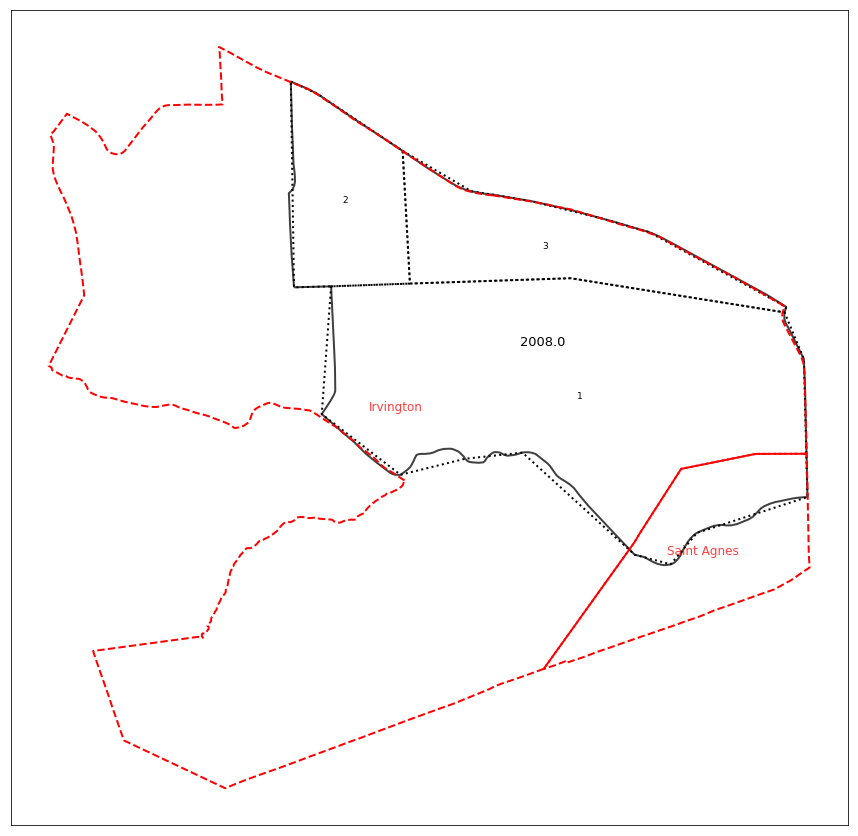

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
z = tracts_2010_gdf[(tracts_2010_gdf.index >= 2007.9) & (tracts_2010_gdf.index <= 2008.6)]
z.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle='-', alpha=0.75)
for ix, thisrow in z.iterrows():
    annotator = ix
    ax.annotate(annotator, xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), ha='center', va='center', fontsize=13, alpha=1)
zb = block_group_gdf[block_group_gdf['TRACTCE'].apply(lambda x: x in ['200800'])]
zb.plot(ax=ax, color='none', edgecolor='black', linewidth=2, linestyle=':')
for ix, thisrow in zb.iterrows():
    annotator = thisrow['BLKGRPCE']
    ax.annotate(annotator, xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), ha='center', va='center', fontsize=9, alpha=1)
zz = neighborhood_gdf[neighborhood_gdf.index.map(lambda x: x in ['Irvington', 'Saint Agnes'])]
zz.plot(ax=ax, color='none', edgecolor='red', linewidth=2, linestyle='--')
for ix, thisrow in zz.iterrows():
    annotator = ix
    ax.annotate(annotator, xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), ha='center', va='center', color='red', fontsize=12, alpha=0.75)
#water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax, color='blue')
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)
plt.show()

In [25]:
#neighborhood_gdf[neighborhood_gdf.index.map(lambda x: x[0] == 'A')]
#block_group_gdf[block_group_gdf['TRACTCE'] == '010400']
#print('ok')